<a href="https://colab.research.google.com/github/Gopi138942/gcrportfolio/blob/main/Dl_relu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import time
import matplotlib.pyplot as plt


# Load the MNIST dataset
def load_data():
  data = transforms.Compose([transforms.ToTensor()])

  # Download MNIST dataset
  train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=data)
  test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=data)
  return train_data, test_data



def prepare_data(train_data, test_data):
  # Flatten and normalize data
  X_train = train_data.data.view(train_data.data.size(0), -1).float() / 255
  Y_train = train_data.targets
  X_test = test_data.data.view(test_data.data.size(0), -1).float() / 255
  Y_test = test_data.targets
  return X_train.T, Y_train, X_test.T, Y_test

# One-hot encode the labels
def one_hot(Y, num_classes):
    encode = torch.zeros(num_classes, Y.size(0))
    encode[Y, torch.arange(Y.size(0))] = 1
    return encode



# Initialize parameters (weights and biases)
def initial_weights(input_size, hidden_size, output_size):
    W1 = torch.randn(hidden_size, input_size) * 0.01
    b1 = torch.zeros((hidden_size, 1))
    W2 = torch.randn(output_size, hidden_size) * 0.01
    b2 = torch.zeros((output_size, 1))
    return W1, b1, W2, b2



# Define activation functions
def relu(Z):
    return torch.maximum(Z, torch.tensor(0.0))

def softmax(Z):
    expZ = torch.exp(Z - torch.max(Z))
    return expZ / expZ.sum(axis=0, keepdim=True)

# Cross-entropy loss function
def cross_entropy_loss(A2, Y):
    m = Y.shape[1]
    log_probs = -torch.log(A2[Y.argmax(dim=0), torch.arange(m)])
    return log_probs.sum() / m

# Forward pass
def forward_pass(X, W1, b1, W2, b2):
    Z1 = torch.matmul(W1, X) + b1
    A1 = relu(Z1)
    Z2 = torch.matmul(W2, A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

# Backward pass
def backward_pass(X, Y, Z1, A1, A2, W2):
    m = X.shape[1]

    # Output layer gradients using cross-entropy loss
    dZ2 = A2 - Y
    dW2 = torch.matmul(dZ2, A1.T) / m
    db2 = torch.sum(dZ2, axis=1, keepdim=True) / m

    # Hidden layer gradients
    dA1 = torch.matmul(W2.T, dZ2)
    dZ1 = dA1 * (Z1 > 0)
    dW1 = torch.matmul(dZ1, X.T) / m
    db1 = torch.sum(dZ1, axis=1, keepdim=True) / m

    return dW1, db1, dW2, db2

# Update parameters using SGD
def update_weights(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2

# compute accuracy
def compute_accuracy(X, Y, W1, b1, W2, b2):
    _, _, _, A2 = forward_pass(X, W1, b1, W2, b2)
    predictions = torch.argmax(A2, dim=0)
    accuracy = (predictions == Y.argmax(dim=0)).float().mean()
    return accuracy.item()

# Train the model using mini-batch SGD
def train_model(X_train, Y_train, X_test, Y_test, input_size, hidden_size, output_size, epochs, batch_size, learning_rate):
    W1, b1, W2, b2 = initial_weights(input_size, hidden_size, output_size)
    accuracy_list = []
    for epoch in range(epochs):

        for batch in range(X_train.shape[1] // batch_size):
            start, end = batch * batch_size, (batch + 1) * batch_size
            X_batch, Y_batch = X_train[:, start:end], Y_train[:, start:end]

            Z1, A1, Z2, A2 = forward_pass(X_batch, W1, b1, W2, b2)
            loss = cross_entropy_loss(A2, Y_batch)
            dW1, db1, dW2, db2 = backward_pass(X_batch, Y_batch, Z1, A1, A2, W2)
            W1, b1, W2, b2 = update_weights(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

        # Print accuracy at specific epochs (25, 50, 100, 150)
        if (epoch + 1) in [25, 50, 100, 150]:
            train_accuracy, test_accuracy = compute_accuracy(X_train, Y_train, W1, b1, W2, b2), compute_accuracy(X_test, Y_test, W1, b1, W2, b2)
            print(f"Epoch {epoch + 1}:")
            print(f"Training accuracy: {train_accuracy * 100:.2f}%")
            print(f"Test accuracy: {test_accuracy * 100:.2f}%")
            accuracy_list.append((test_accuracy))

    return W1, b1, W2, b2, accuracy_list


In [2]:

# Main function to load data and train the model
def main():
    # Load data
    train_data, test_data = load_data()
    X_train, Y_train, X_test, Y_test = prepare_data(train_data, test_data)

    # One-hot encode labels
    Y_train = one_hot(Y_train, 10)
    Y_test = one_hot(Y_test, 10)

    # Set hyperparameters
    input_size = 784  # MNIST image size (28x28)
    hidden_size = 100  # Number of neurons in the hidden layer
    output_size = 10   # Number of classes (0-9)
    epochs = 150
    learning_rate = 0.01

    # SGD (batch_size = 1)
    print("Training with SGD (batch_size = 1)")
    start_time = time.time()
    W1_sgd, b1_sgd, W2_sgd, b2_sgd, accuracy_sgd = train_model(X_train, Y_train, X_test, Y_test, input_size, hidden_size, output_size, epochs, batch_size=1, learning_rate=learning_rate)
    sgd_time = time.time() - start_time
    print(f"SGD completed in {sgd_time:.2f} seconds.\n")

    # Mini-batch SGD (batch_size = 10)
    print("Training with Mini-batch SGD (batch_size = 10)")
    start_time = time.time()
    W1_mini, b1_mini, W2_mini, b2_mini, accuracy_mini = train_model(X_train, Y_train, X_test, Y_test, input_size, hidden_size, output_size, epochs, batch_size=10, learning_rate=learning_rate)
    mini_batch_time = time.time() - start_time
    print(f"Mini-batch SGD completed in {mini_batch_time:.2f} seconds.\n")

if __name__ == "__main__":
    main()


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 60.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.02MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 15.1MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.16MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training with SGD (batch_size = 1)
Epoch 25:
Training accuracy: 100.00%
Test accuracy: 97.98%
Epoch 50:
Training accuracy: 100.00%
Test accuracy: 97.98%
Epoch 100:
Training accuracy: 100.00%
Test accuracy: 98.03%
Epoch 150:
Training accuracy: 100.00%
Test accuracy: 98.01%
SGD completed in 3967.37 seconds.

Training with Mini-batch SGD (batch_size = 10)
Epoch 25:
Training accuracy: 99.02%
Test accuracy: 97.75%
Epoch 50:
Training accuracy: 99.74%
Test accuracy: 97.80%
Epoch 100:
Training accuracy: 99.99%
Test accuracy: 98.02%
Epoch 150:
Training accuracy: 100.00%
Test accuracy: 97.93%
Mini-batch SGD completed in 504.24 seconds.



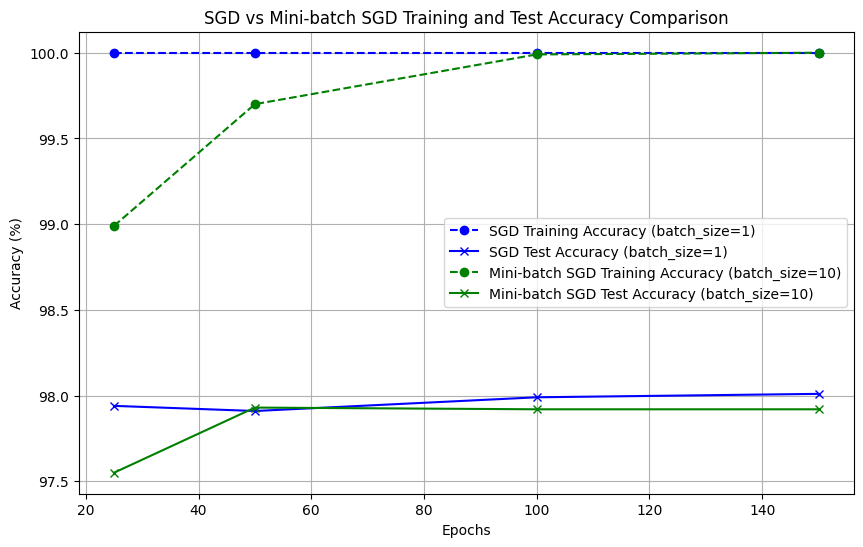

In [3]:
import matplotlib.pyplot as plt

# Function to plot the comparison between SGD and Mini-batch SGD for both training and test accuracy
def plot_sgd_vs_minibatch(train_sgd_accuracies, test_sgd_accuracies, train_minibatch_accuracies, test_minibatch_accuracies):
    # Extract epochs and accuracies for training and test
    sgd_epochs_train, sgd_train_accs = zip(*train_sgd_accuracies)
    sgd_epochs_test, sgd_test_accs = zip(*test_sgd_accuracies)

    minibatch_epochs_train, minibatch_train_accs = zip(*train_minibatch_accuracies)
    minibatch_epochs_test, minibatch_test_accs = zip(*test_minibatch_accuracies)

    # Plotting the accuracies
    plt.figure(figsize=(10, 6))

    # Plot SGD training and test accuracies
    plt.plot(sgd_epochs_train, sgd_train_accs, label='SGD Training Accuracy (batch_size=1)', marker='o', linestyle='--', color='b')
    plt.plot(sgd_epochs_test, sgd_test_accs, label='SGD Test Accuracy (batch_size=1)', marker='x', linestyle='-', color='b')

    # Plot Mini-batch SGD training and test accuracies
    plt.plot(minibatch_epochs_train, minibatch_train_accs, label='Mini-batch SGD Training Accuracy (batch_size=10)', marker='o', linestyle='--', color='g')
    plt.plot(minibatch_epochs_test, minibatch_test_accs, label='Mini-batch SGD Test Accuracy (batch_size=10)', marker='x', linestyle='-', color='g')

    # Titles and labels
    plt.title('SGD vs Mini-batch SGD Training and Test Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Training and test accuracies based on your provided data
train_sgd_accuracies = [(25, 100.00), (50, 100.00), (100, 100.00), (150, 100.00)]
test_sgd_accuracies = [(25, 97.94), (50, 97.91), (100, 97.99), (150, 98.01)]

train_minibatch_accuracies = [(25, 98.99), (50, 99.70), (100, 99.99), (150, 100.00)]
test_minibatch_accuracies = [(25, 97.55), (50, 97.93), (100, 97.92), (150, 97.92)]

# Call the plot function
plot_sgd_vs_minibatch(train_sgd_accuracies, test_sgd_accuracies, train_minibatch_accuracies, test_minibatch_accuracies)

Visualizing training data...
Visualizing images...


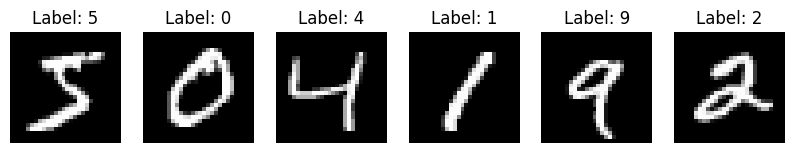

Visualizing test data...
Visualizing images...


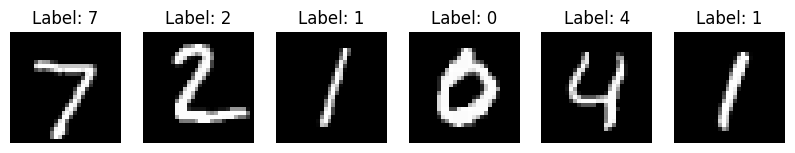

In [4]:

# Function to visualize some images from the dataset
def visualize_images(dataset, num_images=6):
    print("Visualizing images...")
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.squeeze()
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

# Load the dataset and visualize images
train_data, test_data = load_data()

# Visualize training data
print("Visualizing training data...")
visualize_images(train_data)

# Visualize test data
print("Visualizing test data...")
visualize_images(test_data)



Training with 25 neurons in the hidden layer.
Epoch 25:
Training accuracy: 97.31%
Test accuracy: 96.29%
Epoch 50:
Training accuracy: 98.12%
Test accuracy: 96.34%
Epoch 100:
Training accuracy: 98.65%
Test accuracy: 96.16%
Epoch 150:
Training accuracy: 98.99%
Test accuracy: 95.91%
Final Test Accuracy with 25 neurons: 95.91%
Training with 50 neurons in the hidden layer.
Epoch 25:
Training accuracy: 98.56%
Test accuracy: 97.42%
Epoch 50:
Training accuracy: 99.33%
Test accuracy: 97.51%
Epoch 100:
Training accuracy: 99.90%
Test accuracy: 97.42%
Epoch 150:
Training accuracy: 99.99%
Test accuracy: 97.41%
Final Test Accuracy with 50 neurons: 97.41%
Training with 100 neurons in the hidden layer.
Epoch 25:
Training accuracy: 99.00%
Test accuracy: 97.46%
Epoch 50:
Training accuracy: 99.80%
Test accuracy: 97.76%
Epoch 100:
Training accuracy: 100.00%
Test accuracy: 97.85%
Epoch 150:
Training accuracy: 100.00%
Test accuracy: 97.86%
Final Test Accuracy with 100 neurons: 97.86%
Training with 150 neuron

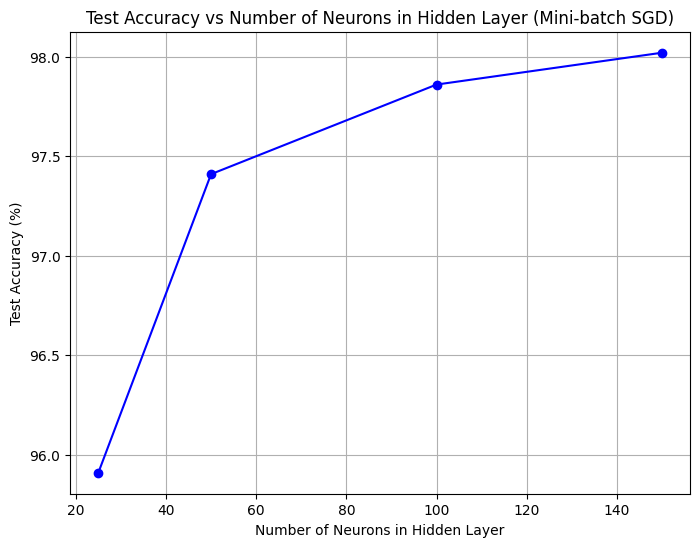

In [5]:
def experiment_with_neurons():
    # Load data
    train_data, test_data = load_data()
    X_train, Y_train, X_test, Y_test = prepare_data(train_data, test_data)

    # One-hot encode labels
    Y_train = one_hot(Y_train, 10)
    Y_test = one_hot(Y_test, 10)

    # Set common hyperparameters
    input_size = 784  # MNIST image size (28x28)
    output_size = 10   # Number of classes (0-9)
    epochs = 150
    learning_rate = 0.01

    # Different hidden layer sizes to experiment with
    hidden_layer_sizes = [25, 50, 100, 150]
    test_accuracies = []

    for hidden_size in hidden_layer_sizes:
        print(f"Training with {hidden_size} neurons in the hidden layer.")

        # Train the model using mini-batch SGD (batch_size = 10)
        W1, b1, W2, b2, acc_mini= train_model(X_train, Y_train, X_test, Y_test, input_size, hidden_size, output_size, epochs, batch_size=10, learning_rate=learning_rate)

        # Evaluate and record the final test accuracy after training
        test_accuracy = compute_accuracy(X_test, Y_test, W1=W1, b1=b1, W2=W2, b2=b2)
        test_accuracies.append(test_accuracy * 100)
        print(f"Final Test Accuracy with {hidden_size} neurons: {test_accuracy * 100:.2f}%")

    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.plot(hidden_layer_sizes, test_accuracies, marker='o', linestyle='-', color='b')
    plt.title('Test Accuracy vs Number of Neurons in Hidden Layer (Mini-batch SGD)')
    plt.xlabel('Number of Neurons in Hidden Layer')
    plt.ylabel('Test Accuracy (%)')
    plt.grid(True)
    plt.show()

# Execute the function to plot the graph
experiment_with_neurons()
    # Modify activation functions: ReLU and tanh



In [6]:
def relu(Z):
  return torch.maximum(Z, torch.tensor(0.0))

def tanh(Z):
  return torch.tanh(Z)

    # Evaluate model accuracy
def evaluate_model(X, Y, W1, b1, W2, b2, activation_func):
  _, _, _, A2 = forward_pass(X, W1, b1, W2, b2, activation_func)
  predictions = torch.argmax(A2, dim=0)
  accuracy = (predictions == Y.argmax(dim=0)).float().mean()
  return accuracy.item()

    # Forward pass
def forward_pass(X, W1, b1, W2, b2, activation_func):
  Z1 = torch.matmul(W1, X) + b1
  A1 = activation_func(Z1)
  Z2 = torch.matmul(W2, A1) + b2
  A2 = softmax(Z2)
  return Z1, A1, Z2, A2

    # Train the model using mini-batch SGD with chosen activation function
def train_model_with_activation(X_train, Y_train, X_test, Y_test, input_size, hidden_size, output_size, epochs, batch_size, learning_rate, activation_func):
        W1, b1, W2, b2 = initial_weights(input_size, hidden_size, output_size)

        test_accuracies = []

        for epoch in range(epochs):
            num_batches = X_train.shape[1] // batch_size

            for batch in range(num_batches):
                start = batch * batch_size
                end = start + batch_size
                X_batch = X_train[:, start:end]
                Y_batch = Y_train[:, start:end]

                # Forward pass using the selected activation function (ReLU or tanh)
                Z1 = torch.matmul(W1, X_batch) + b1
                A1 = activation_func(Z1)
                Z2 = torch.matmul(W2, A1) + b2
                A2 = softmax(Z2)

                # Cross-entropy loss
                loss = cross_entropy_loss(A2, Y_batch)

                # Backward pass
                dZ2 = A2 - Y_batch
                dW2 = torch.matmul(dZ2, A1.T) / batch_size
                db2 = torch.sum(dZ2, axis=1, keepdim=True) / batch_size
                dA1 = torch.matmul(W2.T, dZ2)

                if activation_func == relu:
                    dZ1 = dA1 * (Z1 > 0)
                elif activation_func == tanh:
                    dZ1 = dA1 * (1 - torch.tanh(Z1)**2)

                dW1 = torch.matmul(dZ1, X_batch.T) / batch_size
                db1 = torch.sum(dZ1, axis=1, keepdim=True) / batch_size

                # Update parameters
                W1 -= learning_rate * dW1
                b1 -= learning_rate * db1
                W2 -= learning_rate * dW2
                b2 -= learning_rate * db2

            # Evaluate accuracy at each epoch
            test_accuracy = evaluate_model(X_test, Y_test, W1, b1, W2, b2, activation_func)
            test_accuracies.append(test_accuracy * 100)

            if (epoch + 1) % 25 == 0:
                print(f"Epoch {epoch + 1}: Test Accuracy = {test_accuracy * 100:.2f}%")

        return test_accuracies



Training with ReLU activation function
Epoch 25: Test Accuracy = 97.69%
Epoch 50: Test Accuracy = 97.86%
Epoch 75: Test Accuracy = 97.96%
Epoch 100: Test Accuracy = 97.95%
Epoch 125: Test Accuracy = 97.98%
Epoch 150: Test Accuracy = 97.94%
Training with tanh activation function
Epoch 25: Test Accuracy = 97.53%
Epoch 50: Test Accuracy = 97.92%
Epoch 75: Test Accuracy = 97.99%
Epoch 100: Test Accuracy = 98.03%
Epoch 125: Test Accuracy = 98.01%
Epoch 150: Test Accuracy = 98.03%


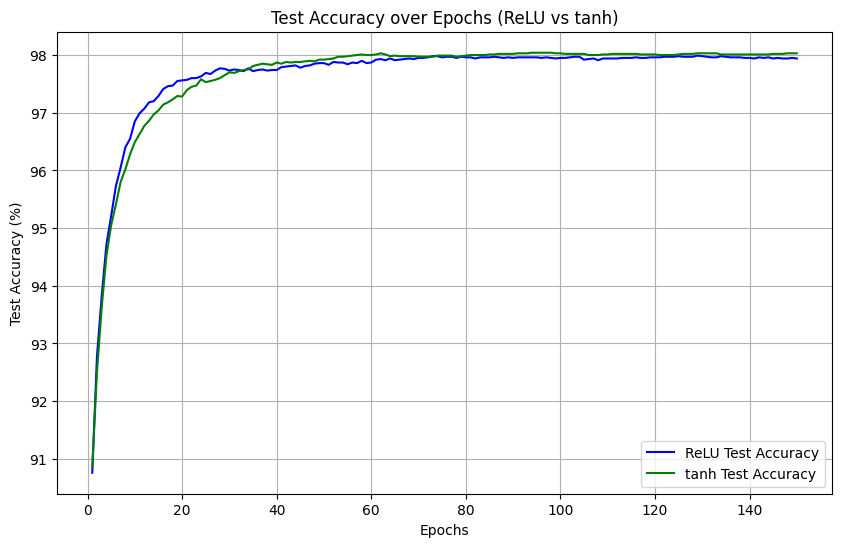

In [7]:
# Experiment function to compare ReLU and tanh activation functions
def experiment_relu_vs_tanh():

        # Load data
        train_data, test_data = load_data()
        X_train, Y_train, X_test, Y_test = prepare_data(train_data, test_data)

        # One-hot encode labels
        Y_train = one_hot(Y_train, 10)
        Y_test = one_hot(Y_test, 10)

        # Set common hyperparameters
        input_size = 784  # MNIST image size (28x28)
        hidden_size = 100  # Fixed hidden layer size
        output_size = 10   # Number of classes (0-9)
        epochs = 150
        learning_rate = 0.01
        batch_size = 10  # mini-batch size

        # Train with ReLU activation
        print("Training with ReLU activation function")
        relu_test_acc = train_model_with_activation(X_train, Y_train, X_test, Y_test, input_size, hidden_size, output_size, epochs, batch_size, learning_rate, relu)

        # Train with tanh activation
        print("Training with tanh activation function")
        tanh_test_acc = train_model_with_activation(X_train, Y_train, X_test, Y_test, input_size, hidden_size, output_size, epochs, batch_size, learning_rate, tanh)

        # Plot the results
        epochs_range = range(1, epochs + 1)
        plt.figure(figsize=(10, 6))

        # ReLU plot
        plt.plot(epochs_range, relu_test_acc, label='ReLU Test Accuracy', color='b')

        # tanh plot
        plt.plot(epochs_range, tanh_test_acc, label='tanh Test Accuracy', color='g')

        plt.title('Test Accuracy over Epochs (ReLU vs tanh)')
        plt.xlabel('Epochs')
        plt.ylabel('Test Accuracy (%)')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Execute the experiment
experiment_relu_vs_tanh()